# Les importations necessaires

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Chargement des données

In [5]:
covid = pd.read_csv("Covid Data.csv", low_memory = False)

# Encodage des données et suppression des valeurs manquantes

In [7]:
columns = [
    "SEX", "USMER", "PATIENT_TYPE", "PNEUMONIA", "DIABETES", 
    "COPD", "ASTHMA", "INMSUPR", "HIPERTENSION", "OTHER_DISEASE",
    "CARDIOVASCULAR", "OBESITY", "RENAL_CHRONIC", "TOBACCO"
]
covid = covid.loc[covid.CLASIFFICATION_FINAL < 4]
for column in columns:
    covid = covid.loc[(covid[column] == 1) | (covid[column] == 2)]


In [8]:
columns = [
    "SEX", "USMER", "PNEUMONIA", "DIABETES", "COPD", 
    "ASTHMA", "INMSUPR", "HIPERTENSION", "OTHER_DISEASE", 
    "CARDIOVASCULAR", "OBESITY", "RENAL_CHRONIC", "TOBACCO", 
    "PREGNANT", "INTUBED", "ICU"
]
for column in columns:
    covid[column] = covid[column].apply(lambda x: x if x == 1 else 0)
covid["PATIENT_TYPE"] = covid["PATIENT_TYPE"].apply(lambda x: 0 if x == 1 else 1)
covid["DATE_DIED"] = covid["DATE_DIED"].apply(lambda x: 0 if x == "9999-99-99" else 1)


In [9]:
covid.shape

(388878, 21)

In [10]:
covid

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,0,1,1,0,1,0,1,65,0,0,...,0,0,1,0,0,0,0,0,3,0
2,0,1,0,1,1,1,0,55,0,1,...,0,0,0,0,0,0,0,0,3,0
4,0,1,0,0,1,0,0,68,0,1,...,0,0,1,0,0,0,0,0,3,0
5,0,1,1,1,0,0,1,40,0,0,...,0,0,0,0,0,0,0,0,3,0
6,0,1,1,0,0,0,0,64,0,0,...,0,0,0,0,0,0,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047933,1,13,1,1,0,0,0,77,0,1,...,0,1,1,0,0,0,0,0,3,0
1047934,1,13,1,0,0,0,0,55,0,1,...,0,0,0,0,0,0,0,0,3,0
1047935,1,13,0,0,0,0,0,70,0,0,...,0,0,1,0,0,0,0,0,3,0
1047936,0,13,0,0,0,0,0,32,0,0,...,0,0,0,0,0,0,0,0,3,0


# Fusion et suppréssion des colonnes à forte corrélation pour obtenir la Target

In [12]:
covid['AT_RISK'] = covid['DATE_DIED'] + covid['INTUBED'] + covid['ICU']
covid.AT_RISK = covid.AT_RISK.apply(lambda x: 1 if x > 0 else 0) 
covid.drop(columns = ['CLASIFFICATION_FINAL', 'INTUBED', 'ICU', 'DATE_DIED'], inplace=True)

# Division des données en données d'entraînement et de test

In [14]:
train, validation = train_test_split(covid, test_size=0.1, shuffle=True)
validation, test = train_test_split(validation, test_size=0.5, shuffle=True)

validation_y = validation.AT_RISK.to_numpy()
validation_x = validation.drop(columns = ['AT_RISK']).to_numpy()

test_y = test.AT_RISK.to_numpy()
test_x = test.drop(columns = ['AT_RISK']).to_numpy()

# Entraînement des models

# Decision Tree Model (Arbre de decision)

## Définition des parmètres de l'algorithme

In [18]:
heuristics = ["entropy", "gini"] # Critères d'impurétés
splitters = ["best", "random"] # Stratégie de division
max_depth = [5, 7, 11, 13, 17] # Profondeur de l'arbre
F_scores = {} # Pour mesurer le meilleur critère appliquer aux meilleurs stratégies
Best_score = 0 # Meilleur Scores

In [19]:
train_y = train.AT_RISK.to_numpy()
train_x = train.drop(columns = ['AT_RISK']).to_numpy()

## Application des différents Critères et stratégie dans les différents profondeurs et recuperation du F-Scores

In [21]:
for d in max_depth: # Parcours des différents profondeurs 
    F_scores[d] = np.zeros(len(heuristics)*len(splitters))
    i=0
    for heuristic, splitter in [(heuristic, splitter) for heuristic in heuristics for splitter in splitters]: # Parcours des différents critères et stratégies
        # Création du décision tree
        dt_classifier = DecisionTreeClassifier(criterion=heuristic, splitter=splitter, max_depth=d, class_weight='balanced')
        dt_classifier.fit(train_x, train_y)
        y_pred = dt_classifier.predict(validation_x)

         # Calculer la F-mesure avec sklearn
        F_scores[d][i] = f1_score(validation_y, y_pred, average='weighted')
        # Vérifier si c'est le meilleur modèle
        if F_scores[d][i] > Best_score:
            Best_score = F_scores[d][i]
            Best_model = dt_classifier
        # Visualisation des différents Decisions tree 
        #plt.figure(figsize=(12, 8))
        #plot_tree(dt_classifier, filled=True, class_names=["Classe 0", "Classe 1"])
        #plt.title(f"Tree Visualization: Depth={d}, Heuristic={heuristic}, Splitter={splitter}")
        #plt.show()
        
        i += 1

## Visualisation graphique

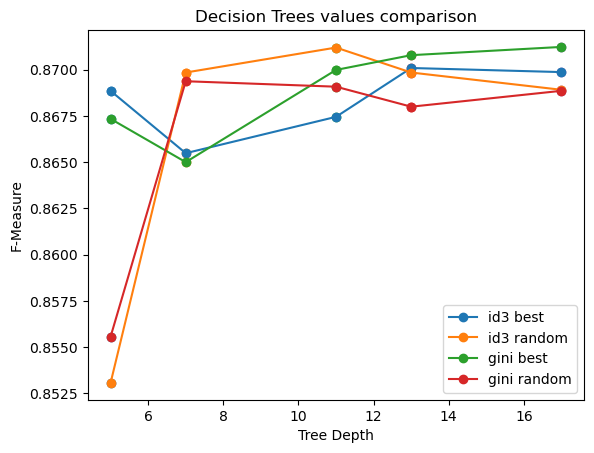

In [23]:
# Initialisation des listes pour stocker les F-mesures par modèle
l1, l2, l3, l4 = [], [], [], []
# Parcours des F-mesures pour chaque profondeur d'arbre (max_depth)
for k in F_scores.keys():
    fmeasures = F_scores[k] 
    # Scatter plot pour chaque profondeur, avec les F-mesures correspondantes
    plt.scatter([k] * len(fmeasures), fmeasures)  
    # Remplissage des listes l1, l2, l3, l4 pour chaque modèle
    l1.append(fmeasures[0])  # id3 best
    l2.append(fmeasures[1])  # id3 random
    l3.append(fmeasures[2])  # gini best
    l4.append(fmeasures[3])  # gini random

# Création des lignes pour chaque modèle avec les F-mesures moyennes
plt.errorbar(max_depth, l1, label='id3 best', fmt='-o')
plt.errorbar(max_depth, l2, label='id3 random', fmt='-o')
plt.errorbar(max_depth, l3, label='gini best', fmt='-o')
plt.errorbar(max_depth, l4, label='gini random', fmt='-o')

# Affichage de la légende et des titres
plt.legend(loc='lower right')
plt.title('Decision Trees values comparison')
plt.xlabel('Tree Depth')
plt.ylabel('F-Measure')

# Affichage de la figure
plt.show()


In [24]:
params = Best_model.get_params()
print('best result for: heuristic = %s, splitter = %s, max depth = %d, F-measure = %f' % (params['criterion'], params['splitter'], params['max_depth'], Best_score))

best result for: heuristic = gini, splitter = best, max depth = 17, F-measure = 0.871222


## Prédiction sur les données de tests

In [27]:
if Best_model is not None:
    y_test_pred = Best_model.predict(test_x)
    
    # Calcul des métriques d'évaluation
    f1 = f1_score(test_y, y_test_pred, average='weighted')
    accuracy = accuracy_score(test_y, y_test_pred)
    precision = precision_score(test_y, y_test_pred, average='weighted')
    recall = recall_score(test_y, y_test_pred, average='weighted')

    # Affichage des résultats
    print(f"Meilleur modèle trouvé avec F-mesure sur validation: {Best_score}")
    print("Évaluation sur l'ensemble de test:")
    print(f"F1-Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
else:
    print("Aucun modèle n'a été trouvé.")

Meilleur modèle trouvé avec F-mesure sur validation: 0.871221872212511
Évaluation sur l'ensemble de test:
F1-Score: 0.8674
Accuracy: 0.8529
Precision: 0.9049
Recall: 0.8529


# Random Forest Model

## Données d'entraînement

In [30]:
train_y = train.AT_RISK.to_numpy()
train_x = train.drop(columns = ['AT_RISK']).to_numpy()

## Définition des paramètres

In [32]:
heuristics = ["entropy", "gini"]
max_depth = [5, 11, 13, 17]
Rf_scores = {}
RBest_result = 0

## Application des différents Critères aux différentes profondeurs et recuperation du F-Scores

In [34]:
for d in max_depth:
    Rf_scores[d] = np.zeros(len(heuristics))
    for (i, heuristic) in enumerate(heuristics):
        # creation du Random Forest
        rf_classifier = RandomForestClassifier(n_estimators=100, criterion=heuristic, max_depth=d,  class_weight='balanced')
        rf_classifier.fit(train_x, train_y)
        y_pred = rf_classifier.predict(validation_x)

        # Calculer la F-mesure avec sklearn
        Rf_scores[d][i] = f1_score(y_pred, validation_y)
        # Verifier si c'est le meilleur model
        if Rf_scores[d][i] > RBest_result:
            RBest_result = Rf_scores[d][i]
            RBest_model = rf_classifier

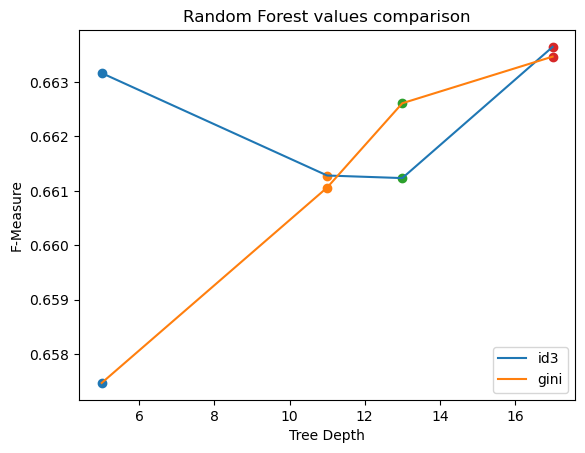

In [35]:
l1, l2 = [], []
for k in Rf_scores.keys():
    fmeasures = Rf_scores[k]
    plt.scatter([k] * len(fmeasures), fmeasures)
    l1.append(Rf_scores[k][0])
    l2.append(Rf_scores[k][1])

# Création des lignes pour chaque modèle avec les F-mesures moyennes + les legendes
plt.errorbar(max_depth, l1, label ='id3')
plt.errorbar(max_depth, l2, label ='gini')
plt.legend(loc ='lower right')
plt.title('Random Forest values comparison')
plt.xlabel('Tree Depth')
plt.ylabel('F-Measure')
plt.show()

In [36]:
params = RBest_model.get_params()
print('Best result for: heuristic = %s, max depth = %d, F-measure = %f' % (params['criterion'], params['max_depth'], RBest_result))

Best result for: heuristic = entropy, max depth = 17, F-measure = 0.663642


## Prédiction sur les données de tests

In [38]:
test_y = test.AT_RISK.to_numpy()
test_x = test.drop(columns = ['AT_RISK']).to_numpy()

In [39]:
# Prédiction sur l'ensemble de test avec le meilleur modèle
if RBest_model is not None:
    Ry_test_pred = RBest_model.predict(test_x)
    # Calcul des métriques d'évaluation
    f1 = f1_score(test_y, Ry_test_pred, average='weighted')
    accuracy = accuracy_score(test_y, Ry_test_pred)
    precision = precision_score(test_y, Ry_test_pred, average='weighted')
    recall = recall_score(test_y, Ry_test_pred, average='weighted')

    # Affichage des résultats
    print(f"Meilleur modèle trouvé avec F-mesure sur validation: {RBest_result}")
    print("Évaluation sur l'ensemble de test:")
    print(f"F1-Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
else:
    print("Aucun modèle n'a été trouvé.")

Meilleur modèle trouvé avec F-mesure sur validation: 0.6636420919974795
Évaluation sur l'ensemble de test:
F1-Score: 0.8723
Accuracy: 0.8582
Precision: 0.9104
Recall: 0.8582


# Q-Learning

## Définition des paramètres Alpha, Gamma et Epsilon

In [42]:
learning_rates = [0.1] # Pour Alpha : Taux d'apprentissage
discount_factors = [0.9] # Pour Gamma : Facteur de reduction
epsilons = [0.1] # Epsilon : Probabilité d'explorer au lieu d'exploiter
episodes = 100 # Nombre d'itération pour que l'agent apprenne la politique
# Initialisation des Q-scores
q_scores = {}
best_score = -np.inf
best_params = None
best_Q = None

## Normalisation des Features et Réduction de la taille de l'ensemble d'entraînements

In [45]:
# Préparation des données
X = covid.drop("AT_RISK", axis=1)
Y = covid["AT_RISK"]

# Division des données en ensembles d'entraînement et de test
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=42)

# Normalisation des features
train_X = (train_X - train_X.mean()) / train_X.std()
test_X = (test_X - test_X.mean()) / test_X.std()

# Réduction de la taille de l'ensemble d'entraînement
sampled_train_X, _, sampled_train_Y, _ = train_test_split(train_X, train_Y, test_size=0.90, stratify=train_Y, random_state=42)
sampled_test_X, _, sampled_test_Y, _ = train_test_split(test_X, test_Y, test_size=0.90, stratify=test_Y, random_state=42)

## Entraînement avec le Q-Learning

In [47]:
reward_progress = {}
for alpha in learning_rates:
    for gamma in discount_factors:
        for epsilon in epsilons:
            # Initialiser les valeurs Q avec des zéros
            n_states = sampled_train_X.shape[0]
            n_actions = 2  # 0: Non Risque COVID, 1: Risque COVID
            Q = np.zeros((n_states, n_actions))
            rewards = []  # Pour suivre les récompenses par épisode

            for episode in range(episodes):
                total_reward = 0
                for i, state in enumerate(sampled_train_X.values):
                    # Choisir une action (Exploration vs Exploitation)
                    if np.random.rand() < epsilon:
                        action = np.random.choice(n_actions)  # Exploration : Se base sur des probabilités et des nombres aléatoire
                    else:
                        action = np.argmax(Q[i, :])  # Exploitation : Se base sur les valeurs du Q-Table (Maximisation) 

                    # Calculer la récompense
                    correct_action = sampled_train_Y.iloc[i]
                    reward = 1 if action == correct_action else -1

                    # Mise à jour Q-value
                    next_state = (i + 1) % n_states
                    best_next_action = np.argmax(Q[next_state, :])
                    Q[i, action] += alpha * (reward + gamma * Q[next_state, best_next_action] - Q[i, action])

                    total_reward += reward

                rewards.append(total_reward)

            # Enregistrer les récompenses cumulées
            reward_progress[(alpha, gamma, epsilon)] = rewards


            # Calcul de la récompense moyenne
            avg_reward = np.mean(rewards[-10:])  # Moyenne des 10 derniers épisodes
            q_scores[(alpha, gamma, epsilon)] = avg_reward

            if avg_reward > best_score:
                best_score = avg_reward
                best_params = (alpha, gamma, epsilon)
                best_Q = Q

# Affichage des meilleurs résultats
print(f"Meilleurs paramètres: Alpha={best_params[0]}, Gamma={best_params[1]}, Epsilon={best_params[2]}")
print(f"Meilleure récompense moyenne: {best_score:.4f}")

Meilleurs paramètres: Alpha=0.1, Gamma=0.9, Epsilon=0.1
Meilleure récompense moyenne: 28030.8000


## Prédiction sur l'ensemble de test

Meilleurs paramètres: Alpha=0.1, Gamma=0.9, Epsilon=0.1
Meilleure récompense moyenne sur l'entraînement: 28030.8000
Évaluation sur l'ensemble de test:
F1-Score: 0.7385
Accuracy: 0.7381
Precision: 0.7389
Recall: 0.7381


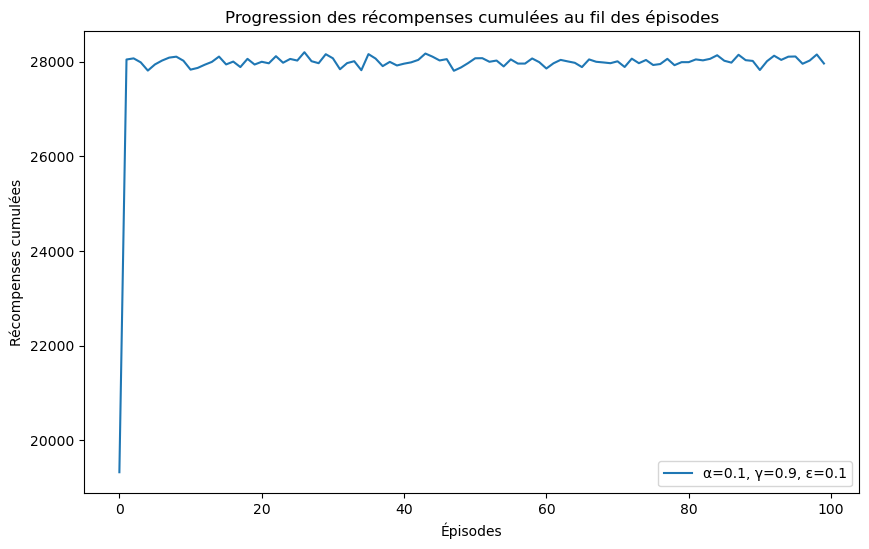

In [49]:
if best_Q is not None:
    # Prédictions sur les données de test
    predictions = []
    for i, state in enumerate(sampled_test_X.values):
        action = np.argmax(best_Q[i % sampled_train_X.shape[0], :])  # Exploitation
        predictions.append(action)

    # Calcul des métriques d'évaluation
    f1 = f1_score(sampled_test_Y, predictions, average="weighted")
    accuracy = accuracy_score(sampled_test_Y, predictions)
    precision = precision_score(sampled_test_Y, predictions, average="weighted")
    recall = recall_score(sampled_test_Y, predictions, average="weighted")

    # Affichage des résultats
    print(f"Meilleurs paramètres: Alpha={best_params[0]}, Gamma={best_params[1]}, Epsilon={best_params[2]}")
    print(f"Meilleure récompense moyenne sur l'entraînement: {best_score:.4f}")
    print("Évaluation sur l'ensemble de test:")
    print(f"F1-Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    # Afficher le graphique des récompenses cumulées
    plt.figure(figsize=(10, 6))
    for key, rewards in reward_progress.items():
        plt.plot(rewards, label=f"α={key[0]}, γ={key[1]}, ε={key[2]}")
    plt.xlabel("Épisodes")
    plt.ylabel("Récompenses cumulées")
    plt.title("Progression des récompenses cumulées au fil des épisodes")
    plt.legend()
    plt.show()
else:
    print("Aucun modèle n'a été trouvé.")